## 합성곱 구현 프로젝트 과제

### 필요한 모듈 임포트

In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras
import time

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [2]:
import time

### cifar10 이미지 로딩

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(type(X_train))
print(X_train.shape)
print ("Training data:")
print ("Number of examples: ", X_train.shape[0])
print ("Number of channels:",X_train.shape[3]) 
print ("Image size:", X_train.shape[1], X_train.shape[2])
print
print ("Test data:")
print ("Number of examples:", X_test.shape[0])
print ("Number of channels:", X_test.shape[3])
print ("Image size:", X_test.shape[1], X_test.shape[2]) 

print(X_train.shape, X_train.dtype)

<class 'numpy.ndarray'>
(50000, 32, 32, 3)
Training data:
Number of examples:  50000
Number of channels: 3
Image size: 32 32
Test data:
Number of examples: 10000
Number of channels: 3
Image size: 32 32
(50000, 32, 32, 3) uint8


### 이미지 시각화

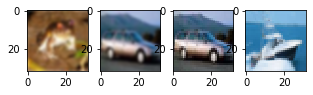

In [4]:
plt.subplot(141)
plt.imshow(X_train[0], interpolation="bicubic")
plt.grid(False)
plt.subplot(142)
plt.imshow(X_train[4], interpolation="bicubic")
plt.grid(False)
plt.subplot(143)
plt.imshow(X_train[4], interpolation="nearest")
plt.grid(False)
plt.subplot(144)
plt.imshow(X_train[8], interpolation="none")
plt.grid(False)
# plt.subplot(145)
# plt.imshow(X_train[12], interpolation="bicubic")
# plt.grid(False)
# plt.show()

### 이미지 정규화 ( 스케일링 )

In [5]:
print ("mean before normalization:", np.mean(X_train)) 
print ("std before normalization:", np.std(X_train))

mean=[0,0,0]
std=[0,0,0]
newX_train = np.ones(X_train.shape, dtype=float)
newX_test = np.ones(X_test.shape, dtype=float)
print(newX_train.shape)
print(newX_test.shape)
for i in range(3):
    print(type(X_train[:,:,:,i]))
    print(X_train[:,:,:,i].shape)
    mean[i] = np.mean(X_train[:,:,:,i])
    std[i] = np.std(X_train[:,:,:,i])
    
for i in range(3):
    newX_train[:,:,:,i] = X_train[:,:,:,i] - mean[i]
    newX_train[:,:,:,i] = newX_train[:,:,:,i] / std[i]
    newX_test[:,:,:,i] = X_test[:,:,:,i] - mean[i]
    newX_test[:,:,:,i] = newX_test[:,:,:,i] / std[i]
        
    
X_train = newX_train
X_test = newX_test

print ("mean after normalization:", np.mean(X_train))
print ("std after normalization:", np.std(X_train))
print(X_train.max())

mean before normalization: 120.70756512369792
std before normalization: 64.1500758911213
(50000, 32, 32, 3)
(10000, 32, 32, 3)
<class 'numpy.ndarray'>
(50000, 32, 32)
<class 'numpy.ndarray'>
(50000, 32, 32)
<class 'numpy.ndarray'>
(50000, 32, 32)
mean after normalization: 4.91799193961621e-17
std after normalization: 0.9999999999999996
2.126789409516928


### 모델 구현 및 훈련 - 재구현 필요

In [6]:
# import tensorflow as tf

# class ConvolutionNetwork:
    
#     def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
#         self.n_kernels = n_kernels  # 합성곱의 커널 개수
#         self.kernel_size = 3        # 커널 크기
#         self.optimizer = None       # 옵티마이저
#         self.conv_w = None          # 합성곱 층의 가중치
#         self.conv_b = None          # 합성곱 층의 절편
#         self.units = units          # 은닉층의 뉴런 개수
#         self.batch_size = batch_size  # 배치 크기
#         self.w1 = None              # 은닉층의 가중치
#         self.b1 = None              # 은닉층의 절편
#         self.w2 = None              # 출력층의 가중치
#         self.b2 = None              # 출력층의 절편
#         self.a1 = None              # 은닉층의 활성화 출력
#         self.losses = []            # 훈련 손실
#         self.val_losses = []        # 검증 손실
#         self.lr = learning_rate     # 학습률

#     def forpass(self, x):
# #         print("x.shape", x.shape)
#         # 3x3 합성곱 연산을 수행합니다.
#         c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
#         # 렐루 활성화 함수를 적용합니다.
#         r_out = tf.nn.relu(c_out)
#         # 2x2 최대 풀링을 적용합니다.
#         p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
#         # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
#         f_out = tf.reshape(p_out, [x.shape[0], -1])
# #         print("f_out.shape", f_out.shape)
#         z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
#         a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
#         z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
#         return z2
    
#     def init_weights(self, input_shape, n_classes):
#         g = tf.initializers.glorot_uniform()
#         self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
# #         print("conv_w",self.conv_w)
# #         print("conv_w.shape",self.conv_w.shape)
#         self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
# #         print("conv_b",self.conv_b)
# #         print("conv_b.shape",self.conv_b.shape)
#         n_features = 14 * 14 * self.n_kernels
#         self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
#         self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
#         self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
#         self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
        
#     def fit(self, x, y, epochs=100, x_val=None, y_val=None):
#         self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
#         self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
#         # epochs만큼 반복합니다.
#         for i in range(epochs):
#             print('에포크', i, end=' ')
#             # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
#             batch_losses = []
#             for x_batch, y_batch in self.gen_batch(x, y):
#                 print('.', end='')
#                 self.training(x_batch, y_batch)
#                 # 배치 손실을 기록합니다.
#                 batch_losses.append(self.get_loss(x_batch, y_batch))
#             print()
#             # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
#             self.losses.append(np.mean(batch_losses))
#             # 검증 세트에 대한 손실을 계산합니다.
#             self.val_losses.append(self.get_loss(x_val, y_val))

#     # 미니배치 제너레이터 함수
#     def gen_batch(self, x, y):
#         bins = len(x) // self.batch_size                   # 미니배치 횟수
#         indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
#         x = x[indexes]
#         y = y[indexes]
#         for i in range(bins):
#             start = self.batch_size * i
#             end = self.batch_size * (i + 1)
#             yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
#     def training(self, x, y):
#         m = len(x)                    # 샘플 개수를 저장합니다.
#         with tf.GradientTape() as tape:
#             z = self.forpass(x)       # 정방향 계산을 수행합니다.
#             # 손실을 계산합니다.
#             loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
#             loss = tf.reduce_mean(loss)

#         weights_list = [self.conv_w, self.conv_b,
#                         self.w1, self.b1, self.w2, self.b2]
#         # 가중치에 대한 그래디언트를 계산합니다.
#         grads = tape.gradient(loss, weights_list)
#         # 가중치를 업데이트합니다.
#         self.optimizer.apply_gradients(zip(grads, weights_list))
   
#     def predict(self, x):
#         z = self.forpass(x)                 # 정방향 계산을 수행합니다.
#         return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    
#     def score(self, x, y):
#         # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
#         return np.mean(self.predict(x) == np.argmax(y, axis=1))

#     def get_loss(self, x, y):
#         z = self.forpass(x)                 # 정방향 계산을 수행합니다.
#         # 손실을 계산하여 저장합니다.
#         loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
#         return loss.numpy()

In [7]:

def get_activation_fn(name):
  if name == 'relu':
    return tf.nn.relu
  elif name == 'softmax':
    return tf.nn.softmax
  elif name == 'sigmoid':
    return tf.math.sigmoid
  elif name == 'tanh':
    return tf.math.tanh
  return None

initializer = tf.initializers.glorot_uniform()

class SimpleConv2D():
  def __init__(self, filters, kernel_size, strides=1, padding='VALID', activation=None, input_shape=None):
    self.filters = filters
    self.kernel_size = kernel_size
    self.padding = padding
    self.strides = strides
    self.activate = get_activation_fn(activation)
    if input_shape is not None and len(input_shape) > 2:
      self.channels = input_shape[2]
      self.conv_w = tf.Variable(initializer((kernel_size,
                                              kernel_size,
                                              self.channels,
                                              filters), dtype=tf.dtypes.float64))#, dtype=tf.dtypes.float64))
      self.conv_b = tf.Variable(np.zeros(filters), dtype=tf.dtypes.float64)
    else:
      self.channels = None
      self.conv_w = None
      self.conv_b = None

  def __call__(self, inputs):
    """
      inputs shape : (batch size, image weight, image height, channels)
    """
    if len(inputs.shape) < 4:
      raise ValueError('SimpleConv2D : invalid the shpae of inputs')
    self.channels = inputs.shape[3]
    if self.conv_w is None:
      self.conv_w =tf.Variable(initializer((self.kernel_size,
                                            self.kernel_size,
                                            self.channels,
                                            self.filters), dtype=tf.dtypes.float64))#, dtype=tf.dtypes.float64))
    if self.conv_b is None:
      self.conv_b = tf.Variable(np.zeros(self.filters), dtype=tf.dtypes.float64)
    #if inputs.dtype is not tf.dtypes.float32:
    #casted_inputs = tf.cast(inputs, dtype=float)
    
    #else:
    casted_inputs = inputs
    out = tf.nn.conv2d(casted_inputs, self.conv_w, self.strides, self.padding) + self.conv_b
    if self.activate is not None:
      out = self.activate(out)
    return out

  def get_trainable_weights(self):
    return [self.conv_w, self.conv_b]

class SimpleDense():
  def __init__(self, units, activation=None):
    self.w = None
    self.b = None
    self.units = units
    self.activate = get_activation_fn(activation)
  
  def __call__(self, inputs):
    """
      inputs shape : (batch size, features)
    """
    if len(inputs.shape) < 2:
      raise ValueError('SimpleDense : invalid the shpae of inputs')
    if self.w is None:
      self.w = tf.Variable(initializer((inputs.shape[1], self.units), dtype=tf.dtypes.float64))
    if self.b is None:
      self.b = tf.Variable(np.zeros(self.units), dtype=tf.dtypes.float64)
    out = tf.matmul(inputs, self.w) + self.b
    if self.activate is not None:
      out = self.activate(out)
    return out

  def get_trainable_weights(self):
    return [self.w, self.b]

class SimpleFlatten():
  def __call__(self, inputs):
    out = tf.reshape(inputs, [inputs.shape[0], -1])
    return out

  def get_trainable_weights(self):
    return None

class SimpleMaxPooling2D():
  def __init__(self, ksize=2, strides=2, padding='VALID'):
    self.ksize = ksize
    self.strides = strides
    self.padding = padding

  def __call__(self, inputs):
    out = tf.nn.max_pool2d(inputs, self.ksize, self.strides, self.padding)
    return out

  def get_trainable_weights(self):
    return None

class SimpleModel():
  def __init__(self):
    self.layers = []

  def add(self, layer):
    self.layers.append(layer)
  
  def compile(self, learning_rate=1e-4, loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy']):
    self.lr = learning_rate
    self.lossfn = tf.keras.losses.get(loss)
    self.optimizer = tf.keras.optimizers.get({'class_name': optimizer, 'config': {'learning_rate': learning_rate}})
    self.metricfn = []
    for metric_name in metrics:
      self.metricfn.append(tf.keras.metrics.Accuracy(name=metric_name))
    self.losses = []
    self.val_losses = []
    self.batch_size = 1

  def get_trainable_weights(self):
    trainable_weights = []
    for layer in self.layers:
      weights = layer.get_trainable_weights()
      if weights is not None:
        trainable_weights += weights
    return trainable_weights

  def get_accuracy(self, lables, predicts):
    accuracy = []
    for m in self.metricfn:
      p = tf.reshape(tf.math.argmax(predicts, axis=1), lables.shape)
      m.update_state(lables, p)
      accuracy.append(m.result().numpy())
    return accuracy
  
  def get_loss(self, train_data, train_labels):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    train_dataset = train_dataset.batch(self.batch_size)
    predictions = []
    y_true = []
    losses = []
    for data, labels in train_dataset: #batch...
      pred, loss = self.call(data, labels)
      losses.append(loss)
      predictions.append(pred)
      y_true.append(labels)
    predictions = tf.concat(predictions, 0)
    y_true = tf.concat(y_true, 0)
    accuracy = self.get_accuracy(y_true, predictions)
    return loss, accuracy
    
  def call(self, data, labels):
    predictions = None
    loss = None
    for layer in self.layers:
      if predictions is None:
        predictions = data
      predictions = layer(predictions)
    loss = tf.reduce_mean(self.lossfn(labels, predictions))
    return predictions, loss

  def fit(self, train_data, train_labels, batch_size=512, epochs=10, valid_data=None, valid_labels=None):
    self.batch_size = batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    if valid_data != None and valid_labels != None:
      valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))
    train_dataset = train_dataset.shuffle(len(train_data)*10).batch(batch_size)
    print_steps = len(train_dataset) // 20
    for i in range(epochs):
      step = 0
      print('Epoch {}/{}'.format(i+1, epochs))
      start_time = time.time()
      print("[=", end="")
      for data, labels in train_dataset: #batch...
        step = step + 1
        if step % print_steps == 0:
          print("=", end="")
        with tf.GradientTape() as tape:
          pred, loss = self.call(data, labels)
        trainable_weights = self.get_trainable_weights()
        gradients = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, trainable_weights))
        self.losses.append(loss.numpy())
      print("]", end="")
      if valid_data != None and valid_labels != None:
        _, val_loss = self.call(valid_data, valid_labels)
        self.val_losses.append(val_loss.numpy())
      duration = time.time() - start_time
      loss, accuracy = self.get_loss(train_data, train_labels)
      print(" {} sec/step - loss : {} - accuracy : {}".format(duration, loss, accuracy))#))
  
  def evaluate(self, test_data, test_labels):
    predicts, loss = self.call(test_data, test_labels)
    accuracy = self.get_accuracy(test_labels, predicts)
    #print('loss : {} - accuracy: {}'.format(loss, accuracy))
    return {'loss':loss, 'accuracy':accuracy}

In [8]:
num_classes = 10     
batchSize = 512                   #-- Training Batch Size
num_epochs = 20                   #-- Number of epochs for training   
learningRate= 0.01                #-- Learning rate for the network
img_rows = 32                     #-- input image dimensions
img_cols = 32 
img_ch=3

model = SimpleModel()
model.add(SimpleConv2D(filters=64, kernel_size=3, activation='relu', padding='SAME', input_shape=(img_rows, img_cols, img_ch)))
model.add(SimpleMaxPooling2D())
model.add(SimpleConv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
model.add(SimpleMaxPooling2D())
model.add(SimpleConv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
model.add(SimpleMaxPooling2D())
model.add(SimpleConv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
model.add(SimpleMaxPooling2D())
model.add(SimpleFlatten())
model.add(SimpleDense(512, activation='relu'))
model.add(SimpleDense(512, activation='relu'))
model.add(SimpleDense(num_classes, activation='softmax'))
model.compile(learning_rate=0.001, loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [9]:
print(len(X_train))
print(len(X_test))

50000
10000


In [10]:
#with tf.device('/cpu:0'):
model.fit(X_train, y_train, batch_size=128, epochs=num_epochs)

Epoch 1/20
[=====================]

(50000, 32, 32, 3)
(50000, 1)
```
Epoch 1/20
98/98 [==============================] - 1s 10ms/step - loss: 1.8578 - accuracy: 0.3077
Epoch 2/20
98/98 [==============================] - 1s 10ms/step - loss: 1.2084 - accuracy: 0.5637
Epoch 3/20
98/98 [==============================] - 1s 10ms/step - loss: 0.9594 - accuracy: 0.6608
Epoch 4/20
98/98 [==============================] - 1s 10ms/step - loss: 0.7753 - accuracy: 0.7287
Epoch 5/20
98/98 [==============================] - 1s 10ms/step - loss: 0.6660 - accuracy: 0.7604
Epoch 6/20
98/98 [==============================] - 1s 10ms/step - loss: 0.5410 - accuracy: 0.8106
Epoch 7/20
98/98 [==============================] - 1s 10ms/step - loss: 0.4436 - accuracy: 0.8434
Epoch 8/20
98/98 [==============================] - 1s 10ms/step - loss: 0.3483 - accuracy: 0.8810
Epoch 9/20
98/98 [==============================] - 1s 10ms/step - loss: 0.2770 - accuracy: 0.9035
Epoch 10/20
98/98 [==============================] - 1s 10ms/step - loss: 0.2047 - accuracy: 0.9307
Epoch 11/20
98/98 [==============================] - 1s 10ms/step - loss: 0.1680 - accuracy: 0.9438
Epoch 12/20

98/98 [==============================] - 1s 10ms/step - loss: 0.0695 - accuracy: 0.9757
Epoch 19/20
98/98 [==============================] - 1s 10ms/step - loss: 0.0669 - accuracy: 0.9767
Epoch 20/20
98/98 [==============================] - 1s 10ms/step - loss: 0.0404 - accuracy: 0.9873
```

In [10]:
with tf.device('/cpu:0'):
    result = model.evaluate(X_test, y_test)
print(result)

loss : 0.958562970161438 - accuracy: [0.6657895]
None
